# Classification Fashion-MNIST
In this project we will build a Sequential Neural Network from scratch using PyTorch library to classify 10 different classes in the fashion-MNIST dataset. The dataset is a 28x28 greyscale images of clothes. We will dive in into the implementation of dropouts to prevent overfitting in the model. 

This project is inspired by:
     1. Facebook Udacity PyTorch Challenge.

First we will create a Neural Network without the regularization implementation, and we will see that overtime our model will perform badly in the validation-set because the more we train our model with the training-set the better it gets by classifying specific testing sets but not good in creating a more generalize model for inference. 

### Lets import the Fashion-MNIST dataset

Let's download the dataset using torchvision, typically we seperate 20% of the dataset for validation set. But in this case we will download the dataset straight from torchvision

In [41]:
# Making sure that all of the graphs, charts and images will be loaded.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import torch
from torchvision import datasets, transforms
import helper

# Transform the images into tensors and normalize
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# Download the training dataset and transform
traindataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',download=True,train=True,transform=transform)
# Load the data using DataLoader class, create a batch of 64 images and shuffle
trainloader = torch.utils.data.DataLoader(dataset=traindataset, batch_size=64, shuffle=True)

# Download the validation dataset and transform
testdataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',download=True,train=False,transform=transform)
# Load the data using DataLoader class, create a batch of 64 images and shuffle
testloader = torch.utils.data.DataLoader(dataset=testdataset, batch_size=64, shuffle=True)

### Define the Neural Network
This model will have 2 hidden layers, the input layer will have 784 units and will have 10 output in the end layer since we have 10 different classes to classify. We will use CrossEntropy loss because of its logarithm nature that will normalize our output close to zero or one.

In [7]:
from torch import nn
from torch.functional import F

class FashionNeuralNetwork(nn.Module):
    '''
    This Neural Network will use ReLU as the non-linear activation function, and 
    use log-softmax activation for the output and negative log likelihood function 
    for our loss function.
    '''
    def __init__(self):
        # Call the super initializor to register all of the layers implemented here
        super().__init__()
        # Create layers here
        self.layer_input = nn.Linear(784,256)
        self.layer_hidden_one = nn.Linear(256,128)
        self.layer_hidden_two = nn.Linear(128,64)
        self.layer_output = nn.Linear(64,10)
    def forward(self, x):
        # Flattened the input to make sure it fits the layer input
        x = x.view(x.shape[0],-1)
        # Pass in the input to the layer and do forward propagation
        x = F.relu(self.layer_input(x))
        x = F.relu(self.layer_hidden_one(x))
        x = F.relu(self.layer_hidden_two(x))
        # Dimension = 1, to get the sum of the output across the output row matrix
        x = F.log_softmax(self.layer_output(x),dim=1)
        return x

Let's check if the output is in the correct shape

In [10]:
# Instantiate the model
model = FashionNeuralNetwork()
# Get the images and labels from the test loader
images, labels = next(iter(testloader))
# Get the log probability prediction from our model
log_ps = model(images)
# Normalize the probability by taking the exponent of the log-prob
ps = torch.exp(log_ps)
# Print out the size
print(ps.shape)

torch.Size([64, 10])


### Measuring the accuracy of our model
Since we want the highest probability of a class, we will use `ps.topk` to get a tuple of top-k values and top-k indices, for example if the highest Kth element is in the 4 element we will get the 3 as the index.

In [11]:
top_p, top_class = ps.topk(1,dim=1)
# Print out the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[8],
        [5],
        [5],
        [8],
        [8],
        [5],
        [5],
        [5],
        [8],
        [5]])


The top_class is a 2D tensor of size 64x1, while our label is a 1D tensor of size 64. To measure the accuracy between the label and our model prediction we have to make sure that the shape of the tensors are the same.

In [20]:
# We have to reshape the labels to 64x1 using the view() method
equals = top_class == labels.view(*top_class.shape)
equals.shape

torch.Size([64, 1])

To calculate the accuracy of our model, simply we can count how many times our model predicted correctly. the == operator above will check row by row if our prediction is the same as the labels. The end result will be binary 0 being not the same and 1 being correctly predicted. We can use torch.mean to calculate the mean however we need to convert the equals to a FloatTensor.

In [21]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
# Print the accuracy
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 12.5%


As you can see, the accuracy is very low. This is very normal since our model will always be initiated with random weights and biases. 

## Train our model
Since we want our loss function to behave oppositely to our Logarithm Softmax function we will use the Negative Log Likelihood to calculate our loss. 

In [24]:
from torch import optim

# Instantiate the model
model = FashionNeuralNetwork()
# Use Negative Log Likelyhood as our loss function
loss_function = nn.NLLLoss()
# Use ADAM optimizer to utilize momentum and start with a very small learning rate
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Train the model 30 cycles
epochs = 30
# Initialize two empty arrays to hold the train and test loss every cycle
train_losses, test_losses = [],[]

# Start the training
for i in range(epochs):
    running_loss = 0
    # Loop through all of the train set forward and back propagate
    for images,labels in trainloader:
        optimizer.zero_grad()                      # Clear the previous gradients
        log_ps = model(images)                     # Forwardpropagate 
        loss = loss_function(log_ps, labels)       # Calculate the loss
        loss.backward()                            # Backpropagate
        optimizer.step()                           # Update the weights
        running_loss += loss.item()                # Accumulate the total loss
    
    # Initialize test loss and accuracy to be 0 for every start of cycle    
    test_loss = 0
    accuracy = 0
    
    # Turn off the gradients
    with torch.no_grad():
        # Loop through all of the validation set and calculate the validation loss
        for images, labels in testloader:
            log_ps = model(images)                                 # Forwardpropagate
            ps = torch.exp(log_ps)                                 # Normalize the log-prob
            test_loss += loss_function(log_ps, labels)             # Accumulate test loss
            top_p, top_class = ps.topk(1,dim=1)                    # Get the top probability
            equals = top_class == labels.view(*top_class.shape)    # Compare equality with label
            accuracy += torch.mean(equals.type(torch.FloatTensor)) # Get mean of accuracy
    
    # Append the average losses to the array for plotting       
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    # Print the result
    print("Epoch: {}/{}.. ".format(i+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.516..  Test Loss: 0.434..  Test Accuracy: 0.845
Epoch: 2/30..  Training Loss: 0.390..  Test Loss: 0.421..  Test Accuracy: 0.844
Epoch: 3/30..  Training Loss: 0.357..  Test Loss: 0.395..  Test Accuracy: 0.860
Epoch: 4/30..  Training Loss: 0.335..  Test Loss: 0.381..  Test Accuracy: 0.868
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.360..  Test Accuracy: 0.873
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.371..  Test Accuracy: 0.871
Epoch: 7/30..  Training Loss: 0.291..  Test Loss: 0.411..  Test Accuracy: 0.857
Epoch: 8/30..  Training Loss: 0.282..  Test Loss: 0.375..  Test Accuracy: 0.869
Epoch: 9/30..  Training Loss: 0.275..  Test Loss: 0.377..  Test Accuracy: 0.875
Epoch: 10/30..  Training Loss: 0.266..  Test Loss: 0.379..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.262..  Test Loss: 0.372..  Test Accuracy: 0.873
Epoch: 12/30..  Training Loss: 0.255..  Test Loss: 0.370..  Test Accuracy: 0.879
Epoch: 13/30..  Training Loss: 0.245.

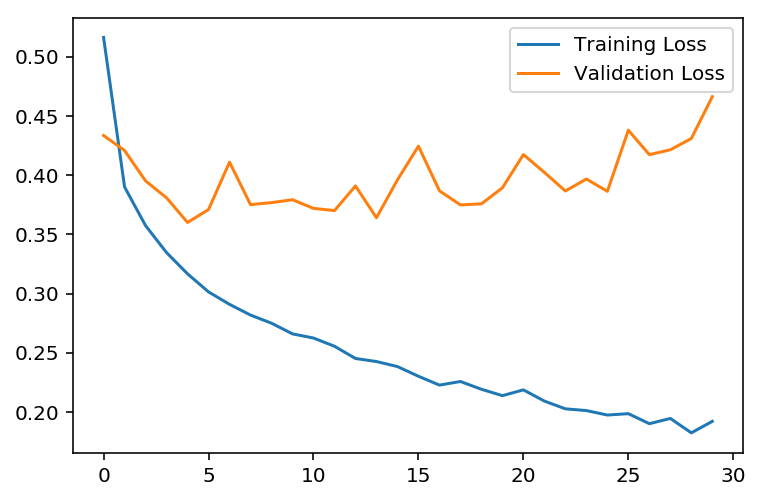

In [35]:
# Plot the graph here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=True)

# Overfitting
We can see clearly from the figure above that our model doesn't generalize good enough. This means that, our model does not do a good job in classifying images outside the training dataset. This is really bad, this means that our model learn the only the specific of our training dataset, which becomes so specialized that it might only recognize images from the training set. If we see from the graph, the training loss decrease significantly every cycle, however we can see the otherwise on the validation loss. 

### Regularization
This is where regularization comes in, one way to do this is to do L2 Regularization, which is called *early-stopping* which basically means that we will stop training our model when the validation loss is at its lowest. In this case our validation loss is at its best after 3-5 epochs. This means that above 5 epochs our model generalization is getting worse every cycle. 

However, there's another way to solve this problem. We can implement dropouts to our model, to generalize more. Esssentially our model acts greedily by snowballing on the large weights and sidelining the other weights to be trained. By having random dropouts, the nodes that has smaller weights will have their chance to be trained during the cycles thus giving a more generalize scores at the end. In other words, it forces the network to share information between weights, which giving more ability to generalize better.

#### Note:
During training we want to implement dropout, however during validation we want our full capability of our model since that's when we can fully measure how accurate our model is to generalize these images. If we use `model.eval()` mode, we will turn off the dropouts and don't forget to turn it again during training by using `model.train()`.

In [37]:
### Define our new Network with Dropouts
class FashionNeuralNetworkD(nn.Module):
    '''
    This Neural Network will be very similar to the first model, however we will add
    20% dropout.
    '''
    def __init__(self):
        # Call the super initializor to register all of the layers implemented here
        super().__init__()
        # Create layers here
        self.layer_input = nn.Linear(784,256)
        self.layer_hidden_one = nn.Linear(256,128)
        self.layer_hidden_two = nn.Linear(128,64)
        self.layer_output = nn.Linear(64,10)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        # Flattened the input to make sure it fits the layer input
        x = x.view(x.shape[0],-1)
        # Pass in the input to the layer and do forward propagation
        x = self.dropout(F.relu(self.layer_input(x)))
        x = self.dropout(F.relu(self.layer_hidden_one(x)))
        x = self.dropout(F.relu(self.layer_hidden_two(x)))
        # Dimension = 1, to get the sum of the output across the output row matrix
        x = F.log_softmax(self.layer_output(x),dim=1)
        return x

Now let's train this model!

In [38]:
# Instantiate the model
model = FashionNeuralNetworkD()
# Use Negative Log Likelyhood as our loss function
loss_function = nn.NLLLoss()
# Use ADAM optimizer to utilize momentum and start with a very small learning rate
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Train the model 30 cycles
epochs = 30
# Initialize two empty arrays to hold the train and test loss every cycle
train_losses, test_losses = [],[]

# Start the training
for i in range(epochs):
    running_loss = 0
    # Loop through all of the train set forward and back propagate
    for images,labels in trainloader:
        optimizer.zero_grad()                      # Clear the previous gradients
        log_ps = model(images)                     # Forwardpropagate 
        loss = loss_function(log_ps, labels)       # Calculate the loss
        loss.backward()                            # Backpropagate
        optimizer.step()                           # Update the weights
        running_loss += loss.item()                # Accumulate the total loss
    
    # Initialize test loss and accuracy to be 0 for every start of cycle    
    test_loss = 0
    accuracy = 0
    
    # Turn off the gradients
    with torch.no_grad():
        # Turn on Evaluation mode
        model.eval()
        # Loop through all of the validation set and calculate the validation loss
        for images, labels in testloader:
            log_ps = model(images)                                 # Forwardpropagate
            ps = torch.exp(log_ps)                                 # Normalize the log-prob
            test_loss += loss_function(log_ps, labels)             # Accumulate test loss
            top_p, top_class = ps.topk(1,dim=1)                    # Get the top probability
            equals = top_class == labels.view(*top_class.shape)    # Compare equality with label
            accuracy += torch.mean(equals.type(torch.FloatTensor)) # Get mean of accuracy

        # Turn on training mode
        model.train()
        
    # Append the average losses to the array for plotting       
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    # Print the result
    print("Epoch: {}/{}.. ".format(i+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.605..  Test Loss: 0.544..  Test Accuracy: 0.815
Epoch: 2/30..  Training Loss: 0.482..  Test Loss: 0.439..  Test Accuracy: 0.838
Epoch: 3/30..  Training Loss: 0.452..  Test Loss: 0.441..  Test Accuracy: 0.843
Epoch: 4/30..  Training Loss: 0.429..  Test Loss: 0.408..  Test Accuracy: 0.854
Epoch: 5/30..  Training Loss: 0.421..  Test Loss: 0.411..  Test Accuracy: 0.855
Epoch: 6/30..  Training Loss: 0.408..  Test Loss: 0.402..  Test Accuracy: 0.854
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.411..  Test Accuracy: 0.853
Epoch: 8/30..  Training Loss: 0.393..  Test Loss: 0.400..  Test Accuracy: 0.857
Epoch: 9/30..  Training Loss: 0.389..  Test Loss: 0.381..  Test Accuracy: 0.866
Epoch: 10/30..  Training Loss: 0.389..  Test Loss: 0.398..  Test Accuracy: 0.859
Epoch: 11/30..  Training Loss: 0.380..  Test Loss: 0.404..  Test Accuracy: 0.857
Epoch: 12/30..  Training Loss: 0.381..  Test Loss: 0.401..  Test Accuracy: 0.865
Epoch: 13/30..  Training Loss: 0.378.

The target here is to have validation loss as low as our training loss, this means that our model is fairly accurate. Let's plot again the graph and see the difference after regularization.

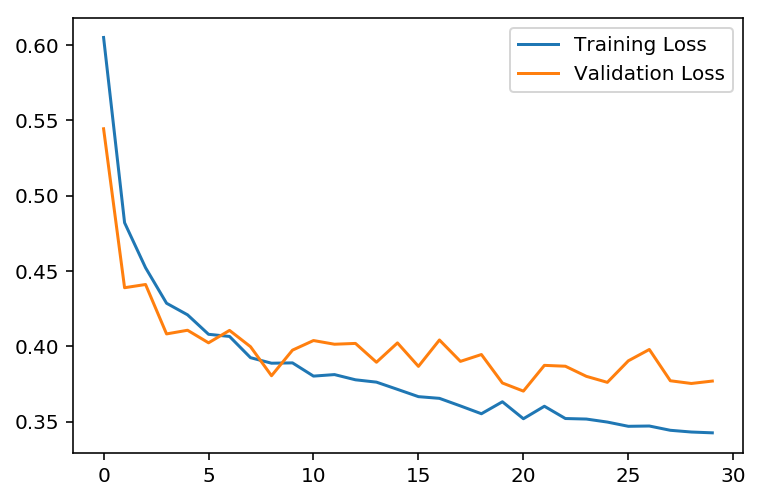

In [39]:
# Plot the graph here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=True)

## Inference
Now that our model can generalize better, let's try to feed our model with an image outside the training data set and visualize the classification of our model.

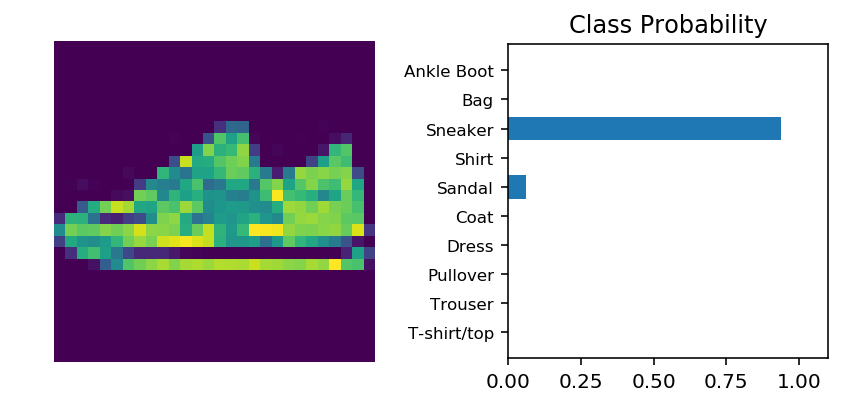

In [46]:
# Make sure to make our model in the evaluation mode
model.eval()
# Get the next image and label
images, labels = next(iter(testloader))
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (log-softmax) for img
with torch.no_grad():
    output = model.forward(img)
# Normalize the output
ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Conclusion
We can see from the graph above that our model generalize better overtime, the model achieve better accuracy after 6-8 epochs and it's safe to say that the model prevent overfitting by implementing dropouts to the model.